In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf


import seaborn as sns
import warnings
import os
from scipy.interpolate import griddata



from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras import datasets, layers, models
from tensorflow import keras
from keras.callbacks import ModelCheckpoint


from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

import meshio
import re

In [2]:
import cfdnetplus

In [3]:
path_to_main= 'airfoil2d/'
folders=['airFoil_1000', 'airFoil_30', 'airFoil_300','airFoil_600', 'airFoil_3000', 'airFoil_2000']
fields= ['U','p','k','omega', 'nut']
xlim =[-50,50]
ylim = [-30 , 30]
xres=256
yres=66
zcut=0.05
modelid='model1'

In [4]:
cfdnetplus.VTK2np(path_to_main,folders, fields,'xy' ,xres,yres,xlim,ylim,zcut)

processing data in airfoil2d/airFoil_1000/VTK/
(339, 66, 256, 7)
339
[266]
data written toairfoil2d/airFoil_1000/VTK/df
processing data in airfoil2d/airFoil_30/VTK/
(600, 66, 256, 7)
600
[555]
data written toairfoil2d/airFoil_30/VTK/df
processing data in airfoil2d/airFoil_300/VTK/
(338, 66, 256, 7)
338
[265]
data written toairfoil2d/airFoil_300/VTK/df
processing data in airfoil2d/airFoil_600/VTK/
(338, 66, 256, 7)
338
[265]
data written toairfoil2d/airFoil_600/VTK/df
processing data in airfoil2d/airFoil_3000/VTK/
(340, 66, 256, 7)
340
[267]
data written toairfoil2d/airFoil_3000/VTK/df
processing data in airfoil2d/airFoil_2000/VTK/
(340, 66, 256, 7)
340
[267]
data written toairfoil2d/airFoil_2000/VTK/df


['airfoil2d/airFoil_1000/VTK/',
 'airfoil2d/airFoil_30/VTK/',
 'airfoil2d/airFoil_300/VTK/',
 'airfoil2d/airFoil_600/VTK/',
 'airfoil2d/airFoil_3000/VTK/',
 'airfoil2d/airFoil_2000/VTK/']

In [15]:

df = np.empty((0,66,256,7))
df_label = np.empty((0,66,256,7))
path_to_folders=[]
for i in folders:
    path_to_folders.append(path_to_main+i+'/VTK/')
    df_t=np.load(path_to_main+i+'/VTK/df.npy')
    df_tlabel=np.load(path_to_main+i+'/VTK/df_label.npy')
    df=np.concatenate((df,df_t))
    df_label=np.concatenate((df_label,df_tlabel))
print(df_label.shape)

FileNotFoundError: [Errno 2] No such file or directory: 'airfoil2d/vae_best_model_relu.epoch01-loss0.00512.w.index/VTK/df.npy'

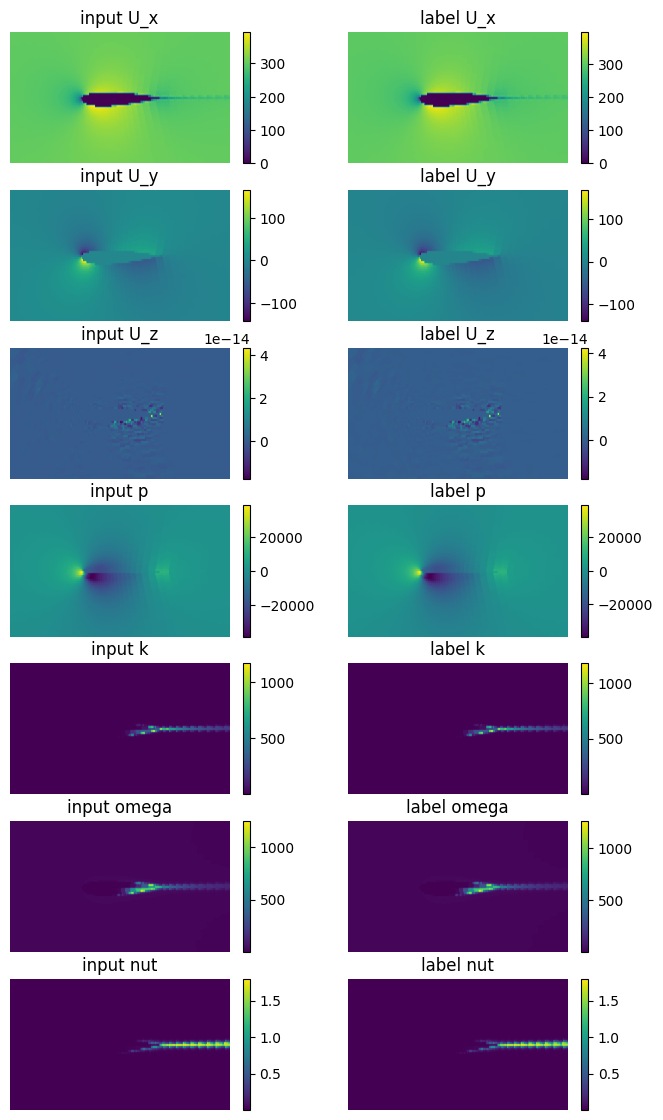

In [10]:

n=1000
fig = plt.figure(figsize=(8, 14))
[a,b,c,d]=df.shape
titles= ['U_x','U_y','U_z','p','k','omega', 'nut']

for i in range(d):
    fig.add_subplot(d, 2, i*2+1)
    plt.imshow(df[n,:,:,i],extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
    plt.title('input ' +titles[i])
    plt.axis('off')
    plt.colorbar()
    
    fig.add_subplot(d, 2, i*2+2)
    plt.imshow(df_label[n,:,:,i],extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
    plt.title('label '+titles[i])
    plt.axis('off')
    plt.colorbar()
    #print(i)

plt.show()

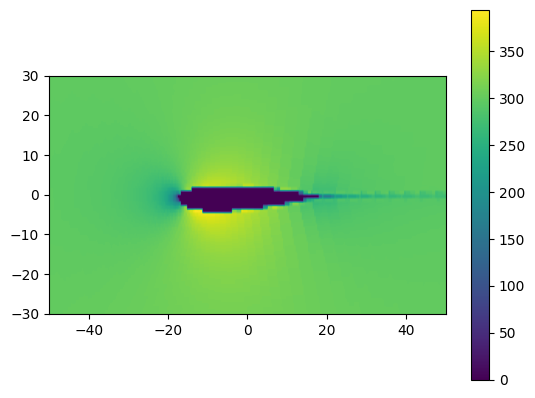

In [11]:
plt.imshow(df[1000,:,:,0],extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
plt.colorbar()

In [16]:
df_label[n,:,:,3].shape

NameError: name 'n' is not defined

In [17]:
#normalise U Vektors
U_max=np.max(abs(df[:,:,:,[0,1,2]]))
p_max=np.max(abs(df[:,:,:,[3]]))
k_max=np.max(abs(df[:,:,:,[4]]))
omega_max=np.max(abs(df[:,:,:,[5]]))
nut_max=np.max(abs(df[:,:,:,[6]]))

model_path='cfdnetplus_models/'+modelid+'/'
normal=np.array([U_max,U_max,U_max, p_max,k_max, omega_max,nut_max]).reshape(1,1,1,7)
print(normal)

if os.path.isdir(model_path)== False:
    os.mkdir(model_path)
np.save(model_path+'normal',normal)


ValueError: zero-size array to reduction operation maximum which has no identity

In [19]:
contents=''
for field in fields:
    contents=contents+field+ '\n'
print(contents)
with open(model_path+'fields',"w") as f:
            f.writelines(contents)
dims=np.array([xres,yres,xlim[0],xlim[1],ylim[0],ylim[1],zcut])
np.save(model_path+'dims',dims)

U
p
k
omega
nut



In [20]:
df1=df*1/normal
df_label1=df_label/normal

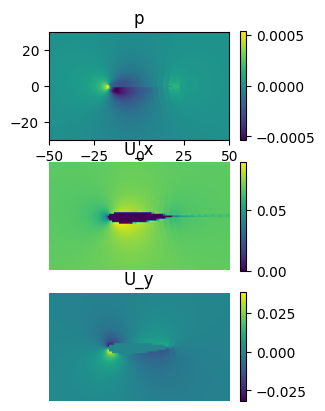

In [21]:
fig = plt.figure()

fig.add_subplot(3, 2, 1)
plt.imshow(df_label1[n,:,:,3],extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
plt.title('p')
plt.axis('on')
plt.colorbar()


fig.add_subplot(3, 2, 3)
plt.imshow(df_label1[n,:,:,0],extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
plt.title('U_x')
plt.axis('off')
plt.colorbar()

fig.add_subplot(3, 2, 5)
plt.imshow(df_label1[n,:,:,1],extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
plt.title('U_y')
plt.axis('off')

plt.colorbar()
plt.show()

In [14]:
train_data, test_data, label_train, label_test = train_test_split (df1, df_label1, test_size = 0.15)

NameError: name 'df1' is not defined

In [102]:
ylim[1]

60

In [5]:
[a,b,c,d]=label_train.shape
fig = plt.figure(figsize=(20, 100))
columns = 4
rows = 20
print(rows)

for i in range( columns * rows):
    img = label_train[(i-1),:,:,3]
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img,extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
    plt.title(i)
    plt.axis('off')
    plt.colorbar(location='bottom')

plt.show()

NameError: name 'label_train' is not defined

In [9]:
# Valid for input with four layers
model = models.Sequential()
model.add(layers.Conv2D(16,( 4,12), (2, 8), activation='tanh',padding="same", input_shape=(66,256, 7)))
model.add(layers.Conv2D(64,(6), (3, 4), activation='tanh',padding="same",))
model.add(layers.Conv2D(256,(16,12), (11, 8), activation='tanh',padding="same",))
model.add(layers.Conv2DTranspose(32,(14,10),(11,8), activation='tanh',padding="same"))
model.add(layers.Conv2DTranspose(16,(6,8),(3,4), activation='tanh',padding="same"))
model.add(layers.Conv2DTranspose(7,(4,16),(2,8), activation='linear', padding="same"))

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 33, 32, 16)        5392      
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 8, 64)         36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 1, 1, 256)         3145984   
                                                                 
 conv2d_transpose (Conv2DTra  (None, 11, 8, 32)        1146912   
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 33, 32, 16)       24592     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 66, 256, 7)       7

In [11]:
model.compile(optimizer='adam',
              loss='mean_squared_error')

In [46]:
folders=os.listdir('training/')
print(folders)
sub='training_'
folders = [x for x in folders if re.search(sub, x)]
#print(len(folders))
if len(folders)==0:
    filefolder=sub+'0'
else:
    id=[]
    for txt in folders:
        t=txt.split('_')
        id.append(int(t[len(t)-1]))
    index_max=np.argmax(id)
    filefolder= sub+str(id[index_max]+1)
print(filefolder)

['training_0']
1
training_1


In [47]:
filepath ='training/'+ filefolder+'/'+'vae_best_model_relu.epoch{epoch:02d}-loss{loss:.5f}.w'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='loss',
                             verbose=1,
                             save_weights_only=True,
                             save_best_only=True,
                             mode='min')
callbacks = [checkpoint]

In [48]:
history = model.fit(train_data, label_train, epochs=100, 
                    validation_data=(test_data, label_test),
                    batch_size=32,
                   callbacks=callbacks)

Epoch 1/100
61/61 [==============================] - ETA: 0s - loss: 6.6054e-05
Epoch 1: loss improved from inf to 0.00007, saving model to training/training_1\vae_best_model_relu.epoch01-loss0.00007.w
61/61 [==============================] - 18s 292ms/step - loss: 6.6054e-05 - val_loss: 7.3764e-05
Epoch 2/100
61/61 [==============================] - ETA: 0s - loss: 1.4871e-05
Epoch 2: loss improved from 0.00007 to 0.00001, saving model to training/training_1\vae_best_model_relu.epoch02-loss0.00001.w
61/61 [==============================] - 17s 285ms/step - loss: 1.4871e-05 - val_loss: 9.2020e-06
Epoch 3/100
61/61 [==============================] - ETA: 0s - loss: 5.8832e-06
Epoch 3: loss improved from 0.00001 to 0.00001, saving model to training/training_1\vae_best_model_relu.epoch03-loss0.00001.w
61/61 [==============================] - 18s 291ms/step - loss: 5.8832e-06 - val_loss: 1.3246e-05
Epoch 4/100
61/61 [==============================] - ETA: 0s - loss: 4.4056e-06
Epoch 4: los

61/61 [==============================] - ETA: 0s - loss: 3.9985e-06
Epoch 35: loss did not improve from 0.00000
61/61 [==============================] - 18s 293ms/step - loss: 3.9985e-06 - val_loss: 7.1429e-06
Epoch 36/100
61/61 [==============================] - ETA: 0s - loss: 5.2347e-06
Epoch 36: loss did not improve from 0.00000
61/61 [==============================] - 18s 295ms/step - loss: 5.2347e-06 - val_loss: 9.9065e-06
Epoch 37/100
61/61 [==============================] - ETA: 0s - loss: 6.6340e-06
Epoch 37: loss did not improve from 0.00000
61/61 [==============================] - 19s 306ms/step - loss: 6.6340e-06 - val_loss: 5.8516e-06
Epoch 38/100
61/61 [==============================] - ETA: 0s - loss: 4.3126e-06
Epoch 38: loss did not improve from 0.00000
61/61 [==============================] - 18s 300ms/step - loss: 4.3126e-06 - val_loss: 7.2527e-06
Epoch 39/100
61/61 [==============================] - ETA: 0s - loss: 3.2695e-06
Epoch 39: loss improved from 0.00000 to 

KeyboardInterrupt: 

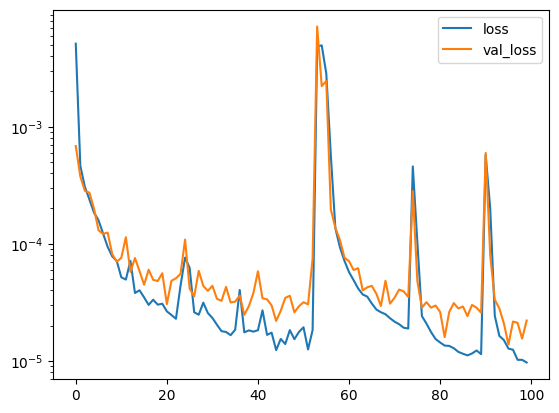

In [34]:
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
#plt.xlabel('Epoch')
#plt.ylabel('loss')
#plt.ylim([0.5, 1])
plt.yscale('log')
plt.legend(loc='upper right')

Finding the last epoch in the training folder

In [7]:
#filefolder= 'training_6'

#folders=os.listdir('training/'+filefolder)
folders=os.listdir('training/'+'training_0/')

sub='index'
folders = [x for x in folders if re.search(sub, x)]

ts=[]
for folder in folders:
    a=re.search('\d{2,3}',folder)
    ts.append(int(a.group(0)))
    #print(a.group(0))
index_max=np.max(ts)
print(index_max)
latest = [x for x in folders if re.search(str(index_max), x)]

latest=latest[0].split('.index')
print(latest[0])

100
vae_best_model_relu.epoch100-loss0.00001.w


In [12]:
#weights_path='training/'+filefolder+'/'+latest[0]

weights_path='training/'+'training_0'+'/'+latest[0]

print(weights_path)
model.load_weights(weights_path)

training/training_0/vae_best_model_relu.epoch100-loss0.00001.w


In [13]:
test=model.predict(test_data)

NameError: name 'test_data' is not defined

In [73]:
print(label_test.shape[0])
n=5
print('max:' , np.max(test[:,:,:,n]))
print('min:' , np.min(test[:,:,:,n]))
#label_test=label_test.reshape((36,66,256,4))
#plt.imshow(np.clip(label_test[1,:,:,3],0,1))

345
max: 0.62837213
min: -0.019497566


(345, 66, 256, 7)


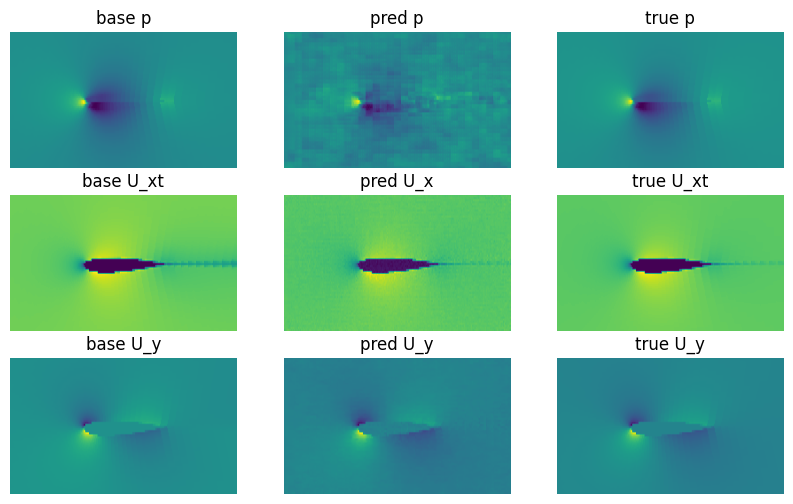

In [63]:
print(test_data.shape)
n=23
fig = plt.figure(figsize=(10, 6))

fig.add_subplot(3, 3, 2)
plt.imshow(test[n,:,:,3],extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
plt.title('pred p')
plt.axis('off')


fig.add_subplot(3, 3,5)
plt.imshow(test[n,:,:,0],extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
plt.title('pred U_x')
plt.axis('off')

fig.add_subplot(3, 3, 8)
plt.imshow(test[n,:,:,1],extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
plt.title('pred U_y')
plt.axis('off')

fig.add_subplot(3, 3, 1)
plt.imshow(test_data[n,:,:,3],extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
plt.title('base p')
plt.axis('off')


fig.add_subplot(3, 3,4)
plt.imshow(test_data[n,:,:,0],extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
plt.title('base U_xt')
plt.axis('off')

fig.add_subplot(3, 3, 7)
plt.imshow(test_data[n,:,:,1],extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
plt.title('base U_y')
plt.axis('off')

fig.add_subplot(3, 3, 3)
plt.imshow(label_test[n,:,:,3],extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
plt.title('true p')
plt.axis('off')


fig.add_subplot(3, 3,6)
plt.imshow(label_test[n,:,:,0],extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
plt.title('true U_xt')
plt.axis('off')

fig.add_subplot(3, 3, 9)
plt.imshow(label_test[n,:,:,1],extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
plt.title('true U_y')
plt.axis('off')

fig.add_subplot(3, 3, 3)
plt.imshow(label_test[n,:,:,3],extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
plt.title('true p')
plt.axis('off')


fig.add_subplot(3, 3,6)
plt.imshow(label_test[n,:,:,0],extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
plt.title('true U_xt')
plt.axis('off')

fig.add_subplot(3, 3, 9)
plt.imshow(label_test[n,:,:,1],extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
plt.title('true U_y')
plt.axis('off')


plt.show()

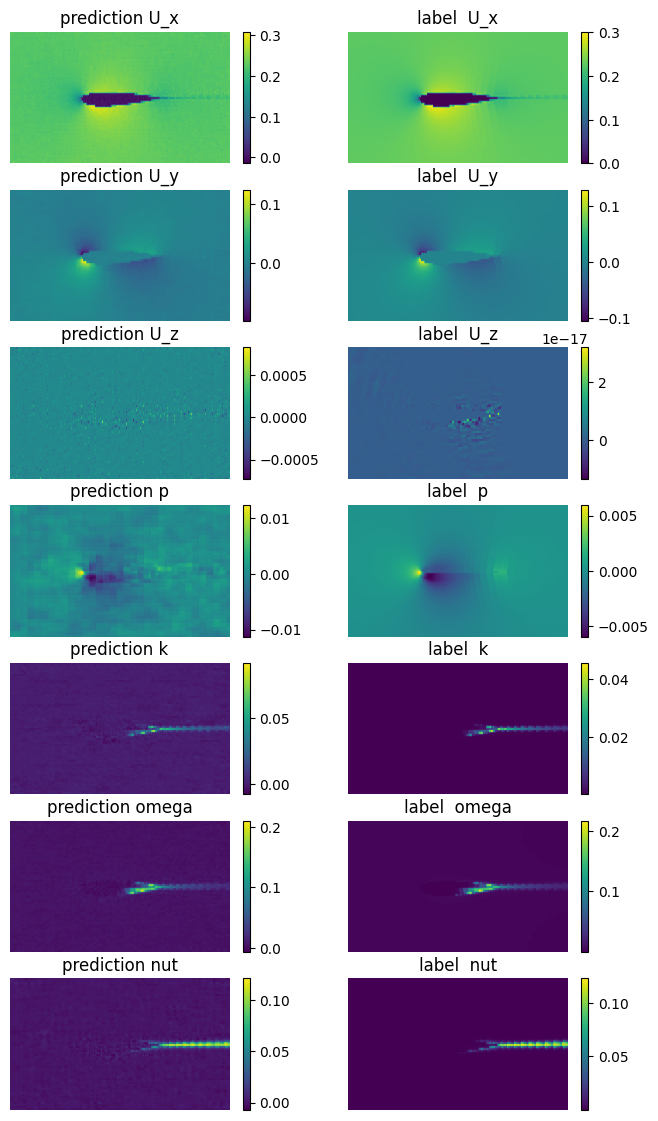

In [76]:
n=23
fig = plt.figure(figsize=(8, 14))
[a,b,c,d]=test.shape
titles= ['U_x','U_y','U_z','p','k','omega', 'nut']

for i in range(d):
    fig.add_subplot(d, 2, i*2+1)
    plt.imshow(test[n,:,:,i],extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
    plt.title('prediction ' +titles[i])
    plt.axis('off')
    plt.colorbar()
    
    fig.add_subplot(d, 2, i*2+2)
    plt.imshow(label_test[n,:,:,i],extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
    plt.title('label  '+titles[i])
    plt.axis('off')
    plt.colorbar()
    #print(i)

plt.show()

In [6]:
[a,b,c,d]=test.shape
fig = plt.figure(figsize=(12, 50))
columns = 4
rows = 21

for i in range( columns * rows):
    img = test[(i-1),:,:,3]
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img,extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
    plt.title(i-1)
    plt.axis('off')
    plt.colorbar()
plt.show()
    

NameError: name 'test' is not defined

In [57]:
mse=[]
ssim1=[]
for i in range(label_test.shape[0]):
    mse.append(mean_squared_error(test[i,:,:,3],label_test[i,:,:,3]))
    ssim1.append(ssim(test[i,:,:,3],label_test[i,:,:,3]))
print('max mse:'+ str(max(mse)))
print(ssim1[n])
print(mse[n])
mse=np.mean(mse)
ssim2=np.mean(ssim1[:])
print('average ssim: '+str(ssim2))
print('average mse: '+str(mse))

C:\Users\hansi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\skimage\_shared\utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


max mse:0.004268981377960514
0.1615901839459936
0.002357455493213041
average ssim: 0.1640604946376105
average mse: 0.002592235416306115


In [43]:
#os.mkdir('cfdnetplus_models')
model.save('cfdnetplus_models/model1')

INFO:tensorflow:Assets written to: cfdnetplus_models/model1\assets


INFO:tensorflow:Assets written to: cfdnetplus_models/model1\assets
